# Monochrome camera calibration
One of the great disadvantages with using lenses is the distortion it introduces to the image. For vacation images, this is usually not a problem, but when we use the image to describe the physical surroundings it becomes important that the images are representative of the scene it captures. An easy way to get an indication of how distorted an image is by looking at what is supposed to be straight lines since they will appear curved. The following exercises you will be calibrating a camera to obtain a camera matrix such that you can undistort images from this camera.

In [8]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

## Exercise 1
The process of calibrating an image consists of mainly 3 steps: 1) find chessboard-corners in a dataset of images containing a chessboard. 2) Use the corner points to compute a camera matrix. 3) Use the camera matrix to undistort images.

After setting some optimization parameters we can loop over all the images in the `imgs` folder and extract the checkerboard corners.

Use any of the images in the folder `imgs` to extract the number of checkerboard corners there are on the checkerboard. Fill in the information in `nb_vertical` and `nb_horizontal` and look up the opencv [findChessboardCorners](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga93efa9b0aa890de240ca32b11253dd4a) function and implement it in the below code snippet .

In [9]:
nb_vertical = 7
nb_horizontal = 6


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nb_horizontal*nb_vertical,3), np.float32)
objp[:,:2] = np.mgrid[0:nb_vertical,0:nb_horizontal].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('imgs/*.png')
assert images


for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    
    #Implement findChessboardCorners here
    ret, corners = cv2.findChessboardCorners(gray, (7,6), None)
    

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nb_vertical,nb_horizontal), corners,ret)
        cv2.imshow('img',img)
        if cv2.waitKey(500) & 0xFF == ord('q'):
            break

cv2.destroyAllWindows()

Using the extracted corners we can obtain a camera matrix that contains the information needed to undistort images

In [15]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
img = cv2.imread('imgs/1403709067387836928.png')
h,  w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
print(roi)

(46, 82, 626, 332)


The last step is to actually undistort an image:

Text(0.5, 1.0, 'Undistorted image')

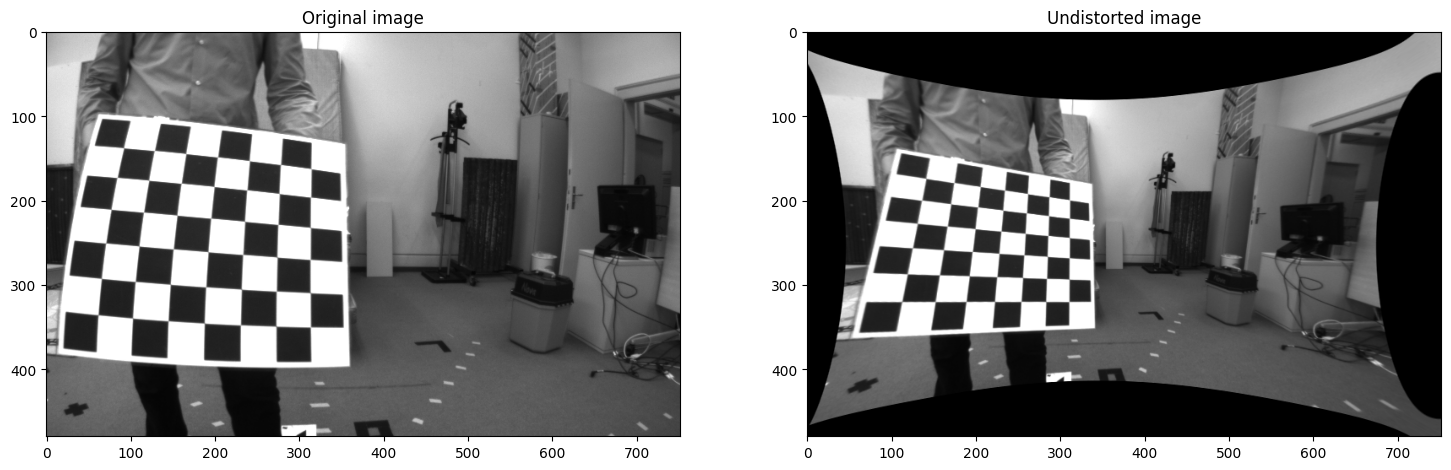

In [16]:
# undistort
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
ax[0].imshow(img[...,[2,1,0]])
ax[0].set_title('Original image')
ax[1].imshow(dst[...,[2,1,0]])
ax[1].set_title('Undistorted image')

A refining step can be to crop the image such that it doesn't contain the large black areas at the edges of the image.

(46, 82, 626, 332)


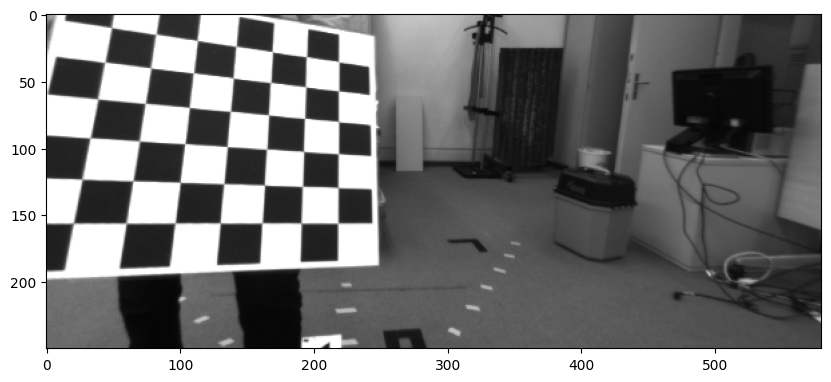

In [18]:
# crop the image
x,y,w,h = roi
print(roi)
dst = dst[y:y+h, x:x+w]
plt.figure(figsize=(10,10))
plt.imshow(dst[...,[2,1,0]])